In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [18]:
df = pd.read_csv('train_data_fixed.csv')
df.head(1)

,tweet,mainlean,secondlean
0,Jokes about Alec Baldwin arent funny imo Yeah ...,Auth,Right


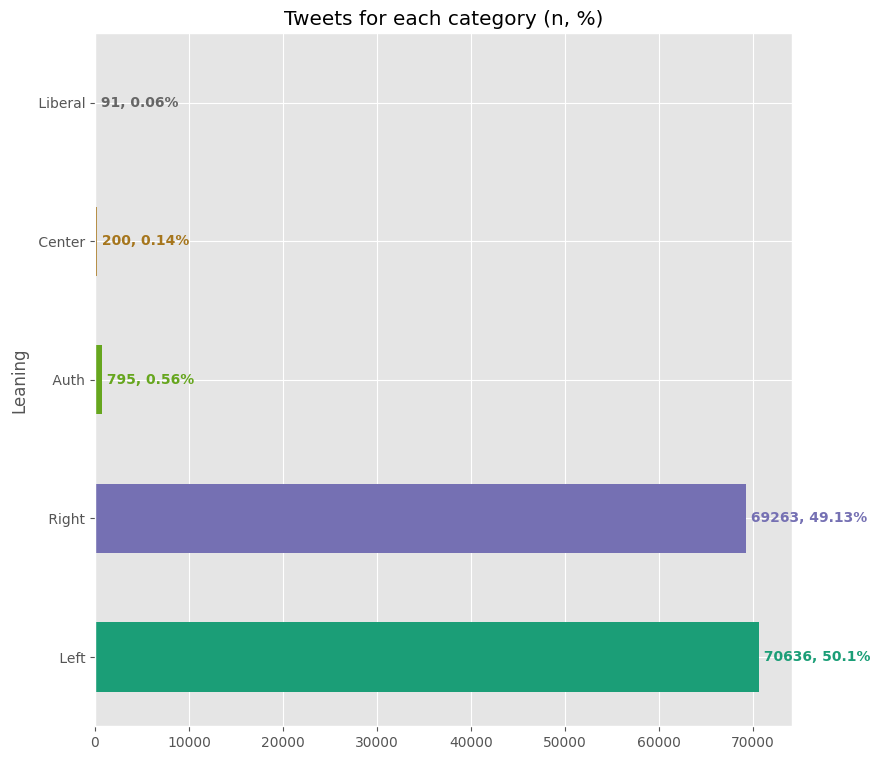

In [11]:
plt.style.use('ggplot')

num_classes = len(df["mainlean"].value_counts())

colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

df['mainlean'].value_counts().plot.barh(title="Tweets for each category (n, %)", ylabel="Leaning",color=colors,figsize=(9,9))

for i, v in enumerate(df['mainlean'].value_counts()):
  c = next(iter_color)
  plt.text(v, i," "+str(v)+", "+str(round(v*100/df.shape[0],2))+"%", color=c, va='center', fontweight='bold')

In [19]:
numConversion = ["left", "right", "center", "auth", "liberal"]
df['mainlean'] = df.mainlean.apply(lambda x: numConversion.index(x.lower().strip()))
df = df.drop(["secondlean"], axis=1)
df.head(1)

,tweet,mainlean
0,Jokes about Alec Baldwin arent funny imo Yeah ...,3


In [21]:
y = tf.keras.utils.to_categorical(df["mainlean"].values, num_classes=num_classes)
x_train, x_test, y_train, y_test = train_test_split(df['tweet'], y, test_size=0.25)

In [22]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [24]:
from keras import backend as K

def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [25]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = embed(i)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.string, name='text'), name='text', description="created by layer 'text'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.